In [ ]:
# system / paths
import os
import sys
from pathlib import Path

# numerical / data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# audio processing
import librosa
import soundfile as sf
# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# project paths
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

cwd = Path().resolve()
project_root = cwd.parents[1]

raw_root = project_root / "data" / "raw" / "icbhi"
audio_dir = raw_root / "audio_and_txt_files"
patient_csv = raw_root / "patient_diagnosis.csv"
demographic_txt = raw_root / "demographic_info.txt"

print("cwd         :", cwd)
print("project_root:", project_root)
print("raw_root    :", raw_root)
print("audio_dir   :", audio_dir)
print("patient_csv :", patient_csv)

# project modules
from src.plot_style import set_default_style
from src.widgets import make_patient_audio_widget

set_default_style()

# plotting defaults
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 5)

# pandas display
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

CWD         : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\notebooks\icbhi
PROJECT_ROOT: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
RAW_ROOT    : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi
AUDIO_DIR   : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\audio_and_txt_files
PATIENT_CSV : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\patient_diagnosis.csv


In [3]:
def audio_file_metadata(path: Path) -> dict:
    info = sf.info(str(path))
    duration_sec = info.frames / info.samplerate
    patient_id = int(path.stem.split("_")[0])
    return {
        "path": str(path),
        "file_name": path.name,
        "samplerate": info.samplerate,
        "frames": info.frames,
        "duration_sec": duration_sec,
        "channels": info.channels,
        "patient_id": patient_id,
    }

def parse_icbhi_filename(file_name: str) -> dict:
    stem = file_name[:-4]  # remove .wav
    parts = stem.split("_")
    chest_location = parts[2] if len(parts) > 2 else None
    mode = parts[3] if len(parts) > 3 else None
    equipment = parts[4] if len(parts) > 4 else None
    return {
        "chest_location": chest_location,
        "mode": mode,
        "equipment": equipment,
    }

demo_cols = [
    "patient_id",
    "age",
    "sex",
    "adult_bmi",
    "child_weight",
    "child_height",
]

In [4]:
demo_df = pd.read_csv(
    DEMOGRAPHIC_TXT,
    sep=r"\s+",
    header=None,
    names=demo_cols,
    engine="python",
)

print("demo_df shape:", demo_df.shape)
demo_df.head()

demo_df shape: (126, 6)


,patient_id,age,sex,adult_bmi,child_weight,child_height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [5]:
wav_paths = sorted(AUDIO_DIR.glob("*.wav"))
records = []

for p in wav_paths:
    meta = audio_file_metadata(p)
    parsed = parse_icbhi_filename(p.name)
    records.append({**meta, **parsed})

audio_df = pd.DataFrame(records)
audio_df.head()


,path,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101,Al,sc,Meditron
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101,Pr,sc,Meditron
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102,Ar,sc,Meditron
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103,Ar,mc,LittC2SE
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104,Al,sc,Litt3200


In [6]:
patients_df = pd.read_csv(PATIENT_CSV, header=None, names=["patient_id", "diagnosis"])

df = audio_df.merge(patients_df, on="patient_id", how="left")
print("df shape:", df.shape)
df.head()


df shape: (920, 11)


,path,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101,Al,sc,Meditron,URTI
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101,Pr,sc,Meditron,URTI
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102,Ar,sc,Meditron,Healthy
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103,Ar,mc,LittC2SE,Asthma
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104,Al,sc,Litt3200,COPD


In [7]:
# Merge demographics into df on patient_id
full_df = df.merge(
    demo_df[["patient_id", "age", "sex"]],
    on="patient_id",
    how="left",
    validate="many_to_one",
)

print("Merged full_df shape:", full_df.shape)
full_df.head()

Merged full_df shape: (920, 13)


,path,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis,age,sex
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101,Al,sc,Meditron,URTI,3.00,F
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101,Pr,sc,Meditron,URTI,3.00,F
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102,Ar,sc,Meditron,Healthy,0.75,F
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103,Ar,mc,LittC2SE,Asthma,70.00,F
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104,Al,sc,Litt3200,COPD,70.00,F


In [9]:
# 2. Basic dataset overview

n_patients = full_df["patient_id"].nunique()
n_recordings = len(full_df)
total_duration_hours = full_df["duration_sec"].sum() / 3600.0

print(f"Number of patients:   {n_patients}")
print(f"Number of recordings: {n_recordings}")
print(f"Total duration:       {total_duration_hours:.2f} hours")

Number of patients:   126
Number of recordings: 920
Total duration:       5.49 hours


In [10]:
print("\nDiagnoses (recording-level):")
print(full_df["diagnosis"].value_counts())


Diagnoses (recording-level):
diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64


In [11]:
print("\nChest locations:")
print(full_df["chest_location"].value_counts())


Chest locations:
chest_location
Ar    168
Al    162
Pl    139
Pr    132
Tc    130
Lr    112
Ll     77
Name: count, dtype: int64


In [12]:
print("\nEquipment types:")
print(full_df["equipment"].value_counts())


Equipment types:
equipment
AKGC417L    646
Meditron    127
LittC2SE     87
Litt3200     60
Name: count, dtype: int64


In [ ]:
print("\nModes:")
print(full_df["mode"].value_counts())


Modes:
mode
mc    732
sc    188
Name: count, dtype: int64


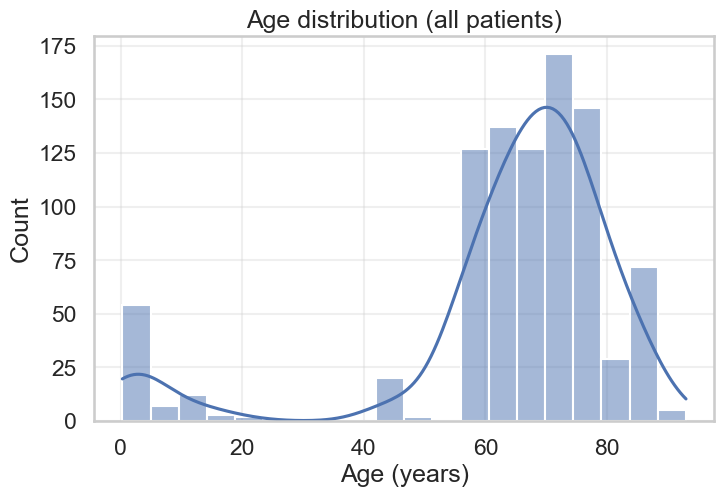

In [14]:
# 3. Demographics (age, sex)

# Age distribution
plt.figure()
sns.histplot(full_df["age"].dropna(), bins=20, kde=True)
plt.title("Age distribution (all patients)")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()


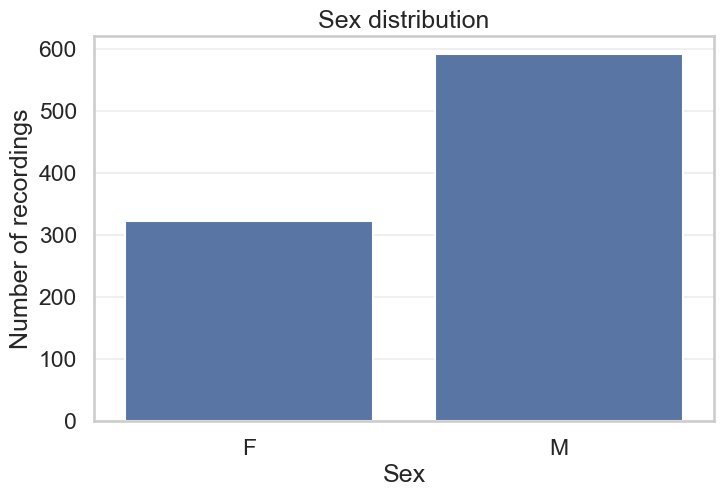

In [15]:
# Sex distribution
plt.figure()
sns.countplot(x="sex", data=full_df)
plt.title("Sex distribution")
plt.xlabel("Sex")
plt.ylabel("Number of recordings")
plt.show()

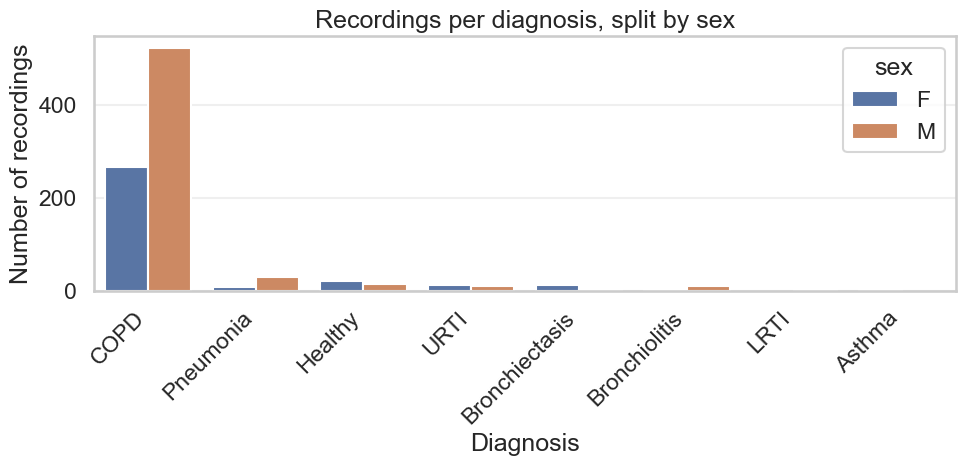

In [16]:
# Diagnosis vs sex (recording-level)
plt.figure(figsize=(10, 5))
sns.countplot(
    x="diagnosis",
    hue="sex",
    data=full_df,
    order=full_df["diagnosis"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Recordings per diagnosis, split by sex")
plt.xlabel("Diagnosis")
plt.ylabel("Number of recordings")
plt.tight_layout()
plt.show()

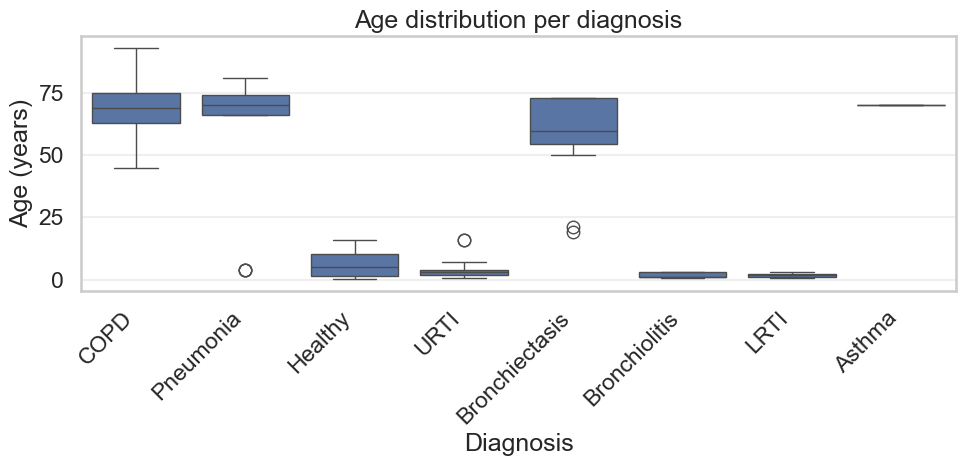

In [17]:
# Age per diagnosis (boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(
    x="diagnosis",
    y="age",
    data=full_df,
    order=full_df["diagnosis"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Age distribution per diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Age (years)")
plt.tight_layout()
plt.show()

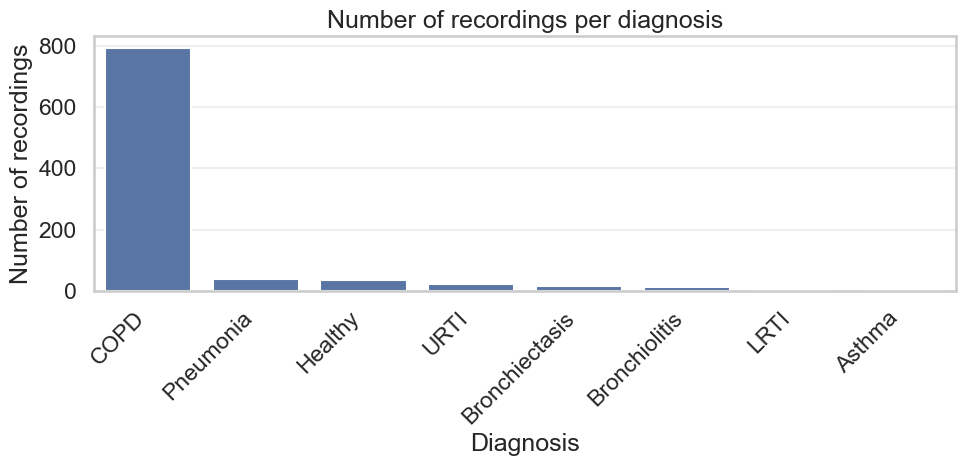

In [18]:
# 4. Diagnosis and recording metadata distributions

# Recordings per diagnosis (recording-level)
plt.figure(figsize=(10, 5))
sns.countplot(
    x="diagnosis",
    data=full_df,
    order=full_df["diagnosis"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Number of recordings per diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Number of recordings")
plt.tight_layout()
plt.show()

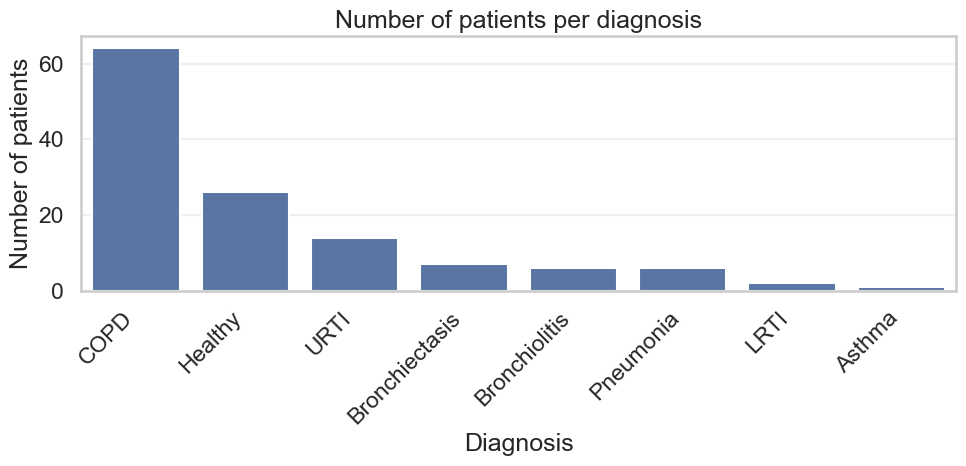

In [ ]:
# Patients per diagnosis (patient-level)
diag_per_patient = (
    full_df.groupby("patient_id")["diagnosis"]
    .agg(lambda x: list(set(x)))
    .explode()
    .value_counts()
)

plt.figure(figsize=(10, 5))
sns.barplot(x=diag_per_patient.index, y=diag_per_patient.values)
plt.xticks(rotation=45, ha="right")
plt.title("Number of patients per diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Number of patients")
plt.tight_layout()
plt.show()

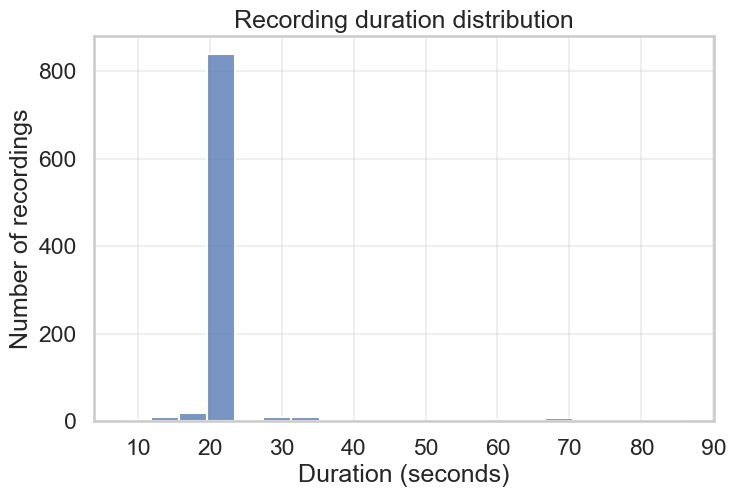

In [20]:
# Duration distribution
plt.figure()
sns.histplot(full_df["duration_sec"], bins=20, kde=False)
plt.title("Recording duration distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of recordings")
plt.show()

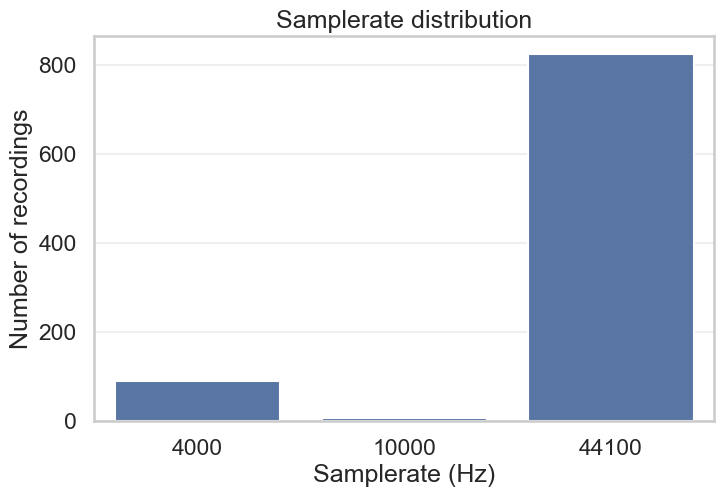

In [ ]:
# Samplerate distribution
plt.figure()
sns.countplot(x="samplerate", data=full_df)
plt.title("Samplerate distribution")
plt.xlabel("Samplerate (Hz)")
plt.ylabel("Number of recordings")
plt.show()

In [25]:
# 5. Audio-level features for signal quality and time-frequency EDA

# Helper functions for simple audio features
def compute_rms(y: np.ndarray) -> float:
    return float(np.sqrt(np.mean(y**2)))


def compute_peak(y: np.ndarray) -> float:
    return float(np.max(np.abs(y)))


def compute_zcr(y: np.ndarray) -> float:
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    return float(np.mean(zcr))


def compute_shannon_entropy(x: np.ndarray) -> float:
    x = np.asarray(x)
    x = x / (np.sum(x) + 1e-12)
    x = x[x > 0]
    return float(-np.sum(x * np.log2(x)))


def compute_spectral_entropy(y: np.ndarray, sr: int, n_fft: int = 1024, hop: int = 512) -> float:
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop))
    psd = np.mean(S**2, axis=1)  # average over time
    return compute_shannon_entropy(psd)


def compute_spectral_centroid(y: np.ndarray, sr: int) -> float:
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    return float(np.mean(centroid))


def compute_spectral_bandwidth(y: np.ndarray, sr: int) -> float:
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    return float(np.mean(bw))


In [26]:
# Choose a subset of recordings for heavy audio computations
max_files_for_audio_eda = 300  # adjust based on speed / resources
all_indices = full_df.index.tolist()
if len(all_indices) > max_files_for_audio_eda:
    sampled_indices = random.sample(all_indices, max_files_for_audio_eda)
else:
    sampled_indices = all_indices

print(f"Computing audio features for {len(sampled_indices)} recordings...")

audio_features = []

for idx in sampled_indices:
    row = full_df.loc[idx]
    path = row["path"]
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
    except Exception as e:
        print(f"Could not load {path}: {e}")
        continue

    # Basic sanity cropping: optional, to limit extremely long files
    # max_len_sec = 30
    # max_samples = int(max_len_sec * sr)
    # if len(y) > max_samples:
    #     y = y[:max_samples]

    rms = compute_rms(y)
    peak = compute_peak(y)
    zcr = compute_zcr(y)
    spec_entropy = compute_spectral_entropy(y, sr)
    spec_centroid = compute_spectral_centroid(y, sr)
    spec_bw = compute_spectral_bandwidth(y, sr)

    audio_features.append(
        {
            "index": idx,
            "path": path,
            "patient_id": row["patient_id"],
            "diagnosis": row["diagnosis"],
            "chest_location": row["chest_location"],
            "equipment": row["equipment"],
            "samplerate": sr,
            "duration_sec": row["duration_sec"],
            "rms": rms,
            "peak": peak,
            "zcr": zcr,
            "spectral_entropy": spec_entropy,
            "spectral_centroid": spec_centroid,
            "spectral_bandwidth": spec_bw,
        }
    )

audio_feat_df = pd.DataFrame(audio_features)
print("Audio feature shape:", audio_feat_df.shape)
audio_feat_df.head()

Computing audio features for 300 recordings...
Audio feature shape: (300, 14)


,index,path,patient_id,diagnosis,chest_location,equipment,samplerate,duration_sec,rms,peak,zcr,spectral_entropy,spectral_centroid,spectral_bandwidth
0,788,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,204,COPD,Ll,AKGC417L,44100,20.000,0.008243,0.081676,0.003723,1.621007,818.374265,2973.937222
1,519,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,172,COPD,Pr,AKGC417L,44100,20.000,0.055019,0.251177,0.007693,1.364196,1797.460076,4306.082822
2,324,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,151,COPD,Ll,AKGC417L,44100,20.000,0.444954,1.000000,0.007538,1.896448,1556.618651,3787.006201
3,197,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,133,COPD,Pr,AKGC417L,44100,20.000,0.156838,1.000000,0.007860,1.404461,1863.746158,4369.131592
4,250,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,139,COPD,Lr,Litt3200,4000,14.576,0.076281,0.999969,0.031623,4.955251,138.851286,174.568191


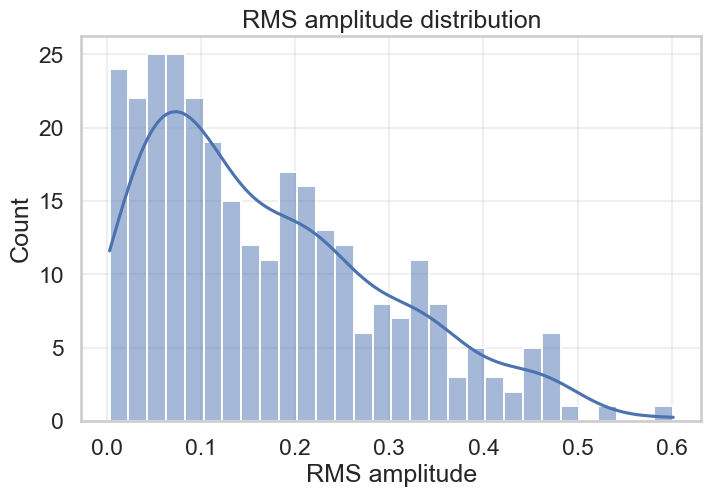

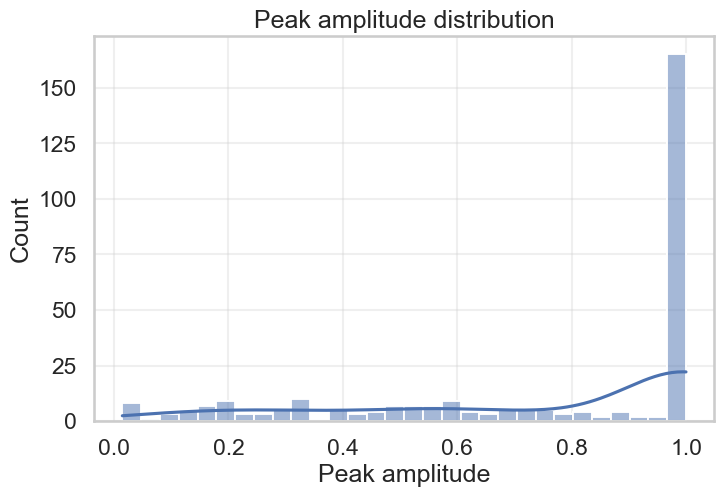

In [27]:
# 6. Signal quality / amplitude & noise proxies

# RMS and peak distributions
plt.figure()
sns.histplot(audio_feat_df["rms"], bins=30, kde=True)
plt.title("RMS amplitude distribution")
plt.xlabel("RMS amplitude")
plt.ylabel("Count")
plt.show()

plt.figure()
sns.histplot(audio_feat_df["peak"], bins=30, kde=True)
plt.title("Peak amplitude distribution")
plt.xlabel("Peak amplitude")
plt.ylabel("Count")
plt.show()


In [28]:
# Potential clipping: near 1.0
clipping_threshold = 0.99
n_clipped = (audio_feat_df["peak"] >= clipping_threshold).sum()
print(f"Recordings with peak >= {clipping_threshold}: {n_clipped} / {len(audio_feat_df)}")

Recordings with peak >= 0.99: 162 / 300


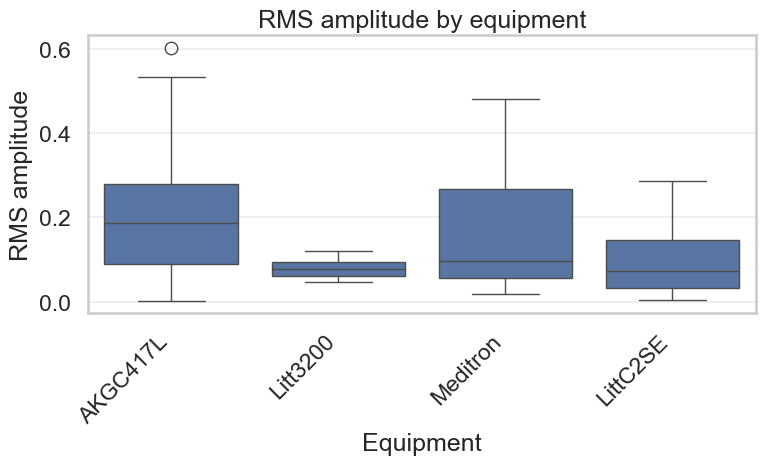

In [29]:
# RMS by equipment
plt.figure(figsize=(8, 5))
sns.boxplot(x="equipment", y="rms", data=audio_feat_df)
plt.xticks(rotation=45, ha="right")
plt.title("RMS amplitude by equipment")
plt.xlabel("Equipment")
plt.ylabel("RMS amplitude")
plt.tight_layout()
plt.show()

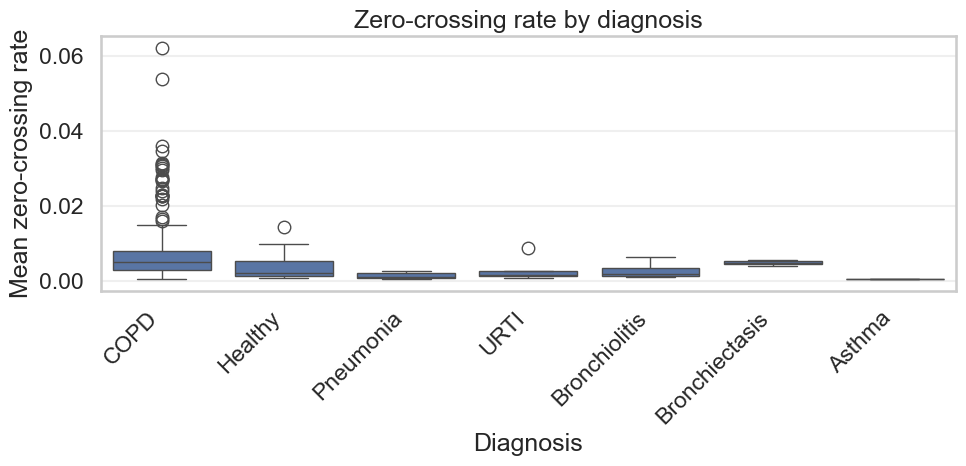

In [30]:
# Zero-crossing rate by diagnosis (rough proxy for noisiness / higher frequencies)
plt.figure(figsize=(10, 5))
sns.boxplot(
    x="diagnosis",
    y="zcr",
    data=audio_feat_df,
    order=audio_feat_df["diagnosis"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Zero-crossing rate by diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Mean zero-crossing rate")
plt.tight_layout()
plt.show()


In [31]:
# 7. Time–frequency characteristics
#    (average spectra per diagnosis)

def compute_average_spectrum_for_group(sub_df, n_fft=2048, hop=512, max_files=50):
    """Compute average magnitude spectrum over a subset of recordings."""
    # Subsample if too many files
    indices = sub_df.index.tolist()
    if len(indices) > max_files:
        indices = random.sample(indices, max_files)

    spectra = []
    freqs_ref = None
    for idx in indices:
        row = sub_df.loc[idx]
        path = row["path"]
        try:
            y, sr = librosa.load(path, sr=None, mono=True)
        except Exception:
            continue

        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop))
        psd = np.mean(S**2, axis=1)  # average over time
        freqs = np.linspace(0, sr / 2, psd.shape[0])

        if freqs_ref is None:
            freqs_ref = freqs
        else:
            # If samplerates differ, you may want to resample or skip
            if not np.allclose(freqs_ref, freqs):
                continue

        spectra.append(psd)

    if not spectra or freqs_ref is None:
        return None, None

    avg_psd = np.mean(np.stack(spectra, axis=0), axis=0)
    return freqs_ref, avg_psd

In [32]:
# Choose a few common diagnoses to compare
top_diagnoses = full_df["diagnosis"].value_counts().index[:4]
avg_spectra = {}

for diag in top_diagnoses:
    sub = full_df[full_df["diagnosis"] == diag]
    freqs, avg_psd = compute_average_spectrum_for_group(sub)
    if freqs is not None:
        avg_spectra[diag] = (freqs, avg_psd)

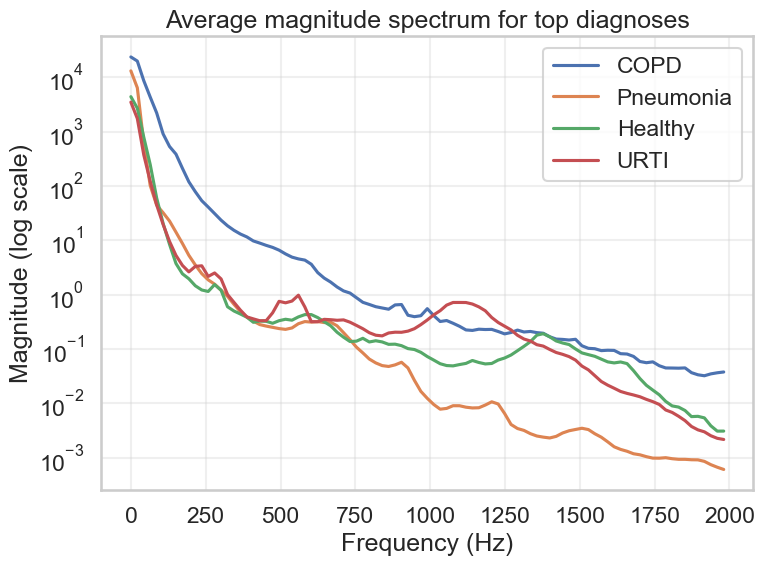

In [33]:
# Plot average spectra
plt.figure(figsize=(8, 6))
for diag, (freqs, psd) in avg_spectra.items():
    # limit to some max frequency for readability, e.g., 2000 Hz
    mask = freqs <= 2000
    freqs_plot = freqs[mask]
    psd_plot = psd[mask]
    plt.semilogy(freqs_plot, psd_plot, label=diag)

plt.title("Average magnitude spectrum for top diagnoses")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

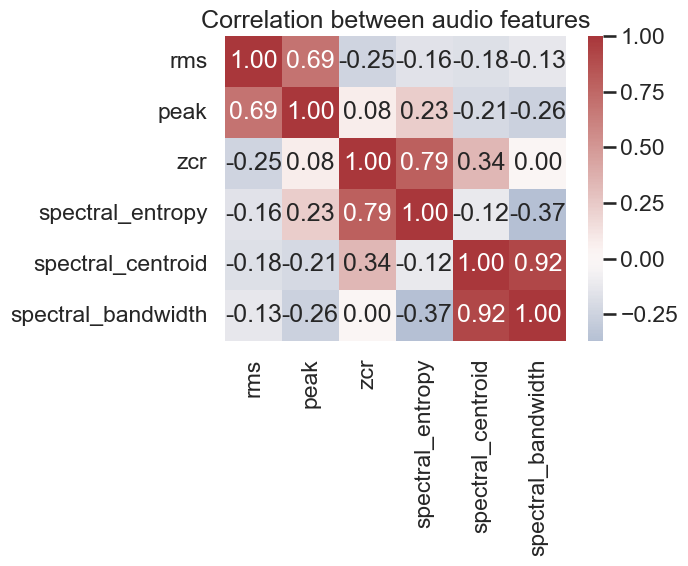

In [35]:
# Correlation matrix of features
corr = audio_feat_df[feature_cols].corr()
plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title("Correlation between audio features")
plt.tight_layout()
plt.show()

In [37]:
# 9. Equipment / site bias via PCA

# Drop rows with missing diagnosis or equipment for PCA
pca_df = audio_feat_df.dropna(subset=feature_cols + ["diagnosis", "equipment"]).copy()

X = pca_df[feature_cols].values
y_diag = pca_df["diagnosis"].values
y_eq = pca_df["equipment"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df["PC1"] = X_pca[:, 0]
pca_df["PC2"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

PCA explained variance ratio: [0.38315215 0.3216168 ]


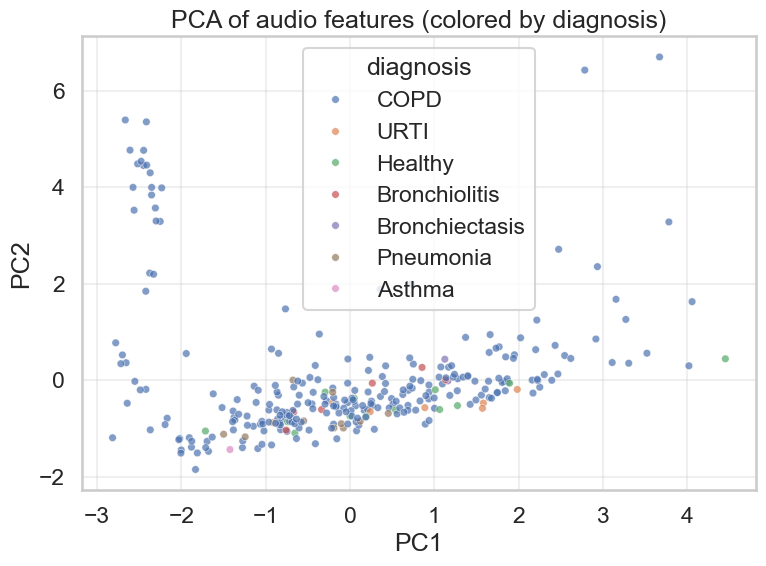

In [ ]:
# Plot PCA colored by diagnosis
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="diagnosis",
    data=pca_df,
    alpha=0.7,
    s=30,
)
plt.title("PCA of audio features (colored by diagnosis)")
plt.tight_layout()
plt.show()

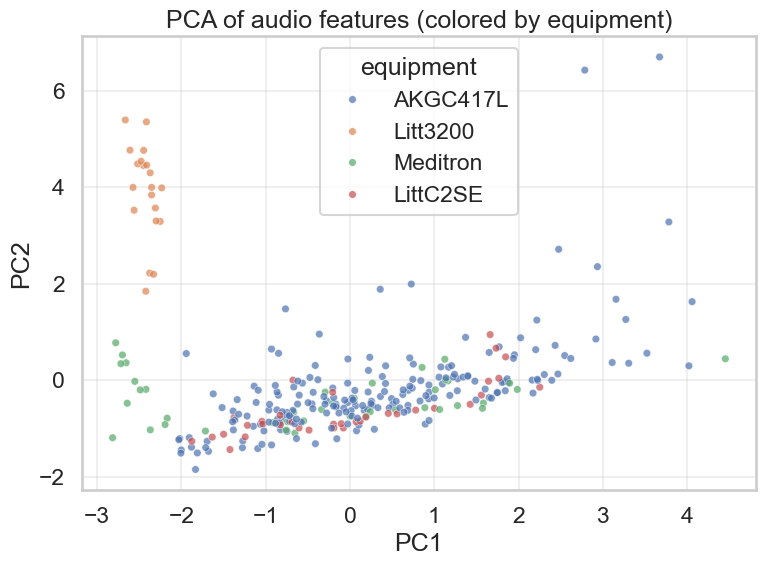

In [39]:
# Plot PCA colored by equipment
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="equipment",
    data=pca_df,
    alpha=0.7,
    s=30,
)
plt.title("PCA of audio features (colored by equipment)")
plt.tight_layout()
plt.show()

In [44]:
make_patient_audio_widget(full_df)